In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv


# Data Loading and Cleaning

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv')

In [4]:
df.head(10)

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon
5,I227836,C657758,Female,28,Clothing,5,1500.40,Credit Card,24/05/2022,Forum Istanbul
6,I121056,C151197,Female,49,Cosmetics,1,40.66,Cash,13/03/2022,Istinye Park
7,I293112,C176086,Female,32,Clothing,2,600.16,Credit Card,13/01/2021,Mall of Istanbul
8,I293455,C159642,Male,69,Clothing,3,900.24,Credit Card,4/11/2021,Metrocity
9,I326945,C283361,Female,60,Clothing,2,600.16,Credit Card,22/08/2021,Kanyon


In [5]:
df.dtypes

invoice_no         object
customer_id        object
gender             object
age                 int64
category           object
quantity            int64
price             float64
payment_method     object
invoice_date       object
shopping_mall      object
dtype: object

In [6]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d/%m/%Y')
df.dtypes

invoice_no                object
customer_id               object
gender                    object
age                        int64
category                  object
quantity                   int64
price                    float64
payment_method            object
invoice_date      datetime64[ns]
shopping_mall             object
dtype: object

In [7]:
df['category'].value_counts()

category
Clothing           34487
Cosmetics          15097
Food & Beverage    14776
Toys               10087
Shoes              10034
Souvenir            4999
Technology          4996
Books               4981
Name: count, dtype: int64

In [8]:
df['payment_method'].value_counts()

payment_method
Cash           44447
Credit Card    34931
Debit Card     20079
Name: count, dtype: int64

In [9]:
df['shopping_mall'].value_counts()

shopping_mall
Mall of Istanbul     19943
Kanyon               19823
Metrocity            15011
Metropol AVM         10161
Istinye Park          9781
Zorlu Center          5075
Cevahir AVM           4991
Forum Istanbul        4947
Viaport Outlet        4914
Emaar Square Mall     4811
Name: count, dtype: int64

In [10]:
df.isnull().sum()

invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
dtype: int64

In [11]:
df.duplicated().sum()

0

# Descriptive Statistics

In [12]:
df.describe()

,age,quantity,price,invoice_date
count,99457.000000,99457.000000,99457.000000,99457
mean,43.427089,3.003429,689.256321,2022-02-04 02:46:59.783424
min,18.000000,1.000000,5.230000,2021-01-01 00:00:00
25%,30.000000,2.000000,45.450000,2021-07-19 00:00:00
50%,43.000000,3.000000,203.300000,2022-02-05 00:00:00
75%,56.000000,4.000000,1200.320000,2022-08-22 00:00:00
max,69.000000,5.000000,5250.000000,2023-03-08 00:00:00
std,14.990054,1.413025,941.184567,NaN


# Time Series Analysis

In [13]:
df.set_index('invoice_date', inplace=True)

In [14]:
daily_sales = df.groupby('invoice_date')['quantity'].sum().reset_index()

In [15]:
mean_sales = daily_sales['quantity'].mean()

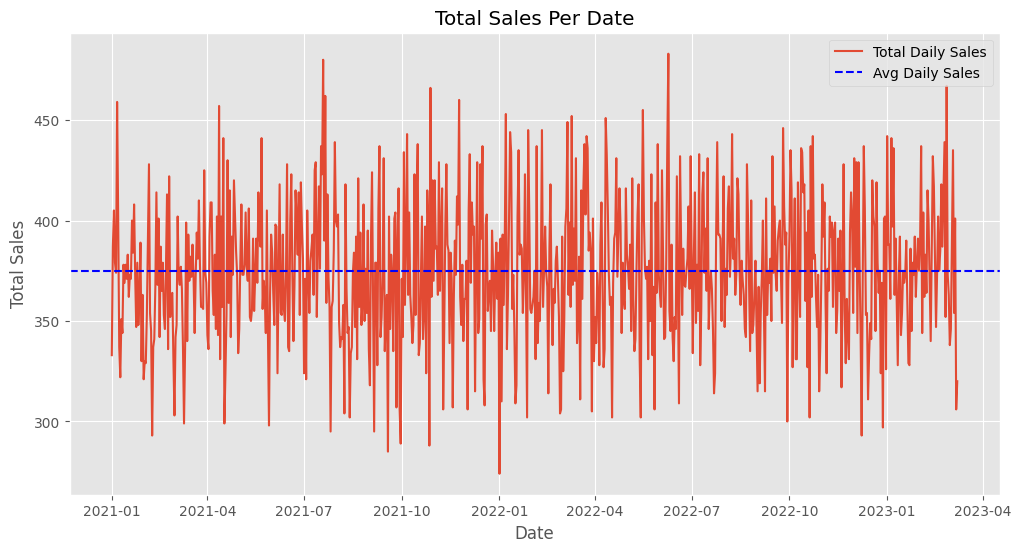

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(daily_sales['invoice_date'], daily_sales['quantity'], label='Total Daily Sales')
ax.set_title('Total Sales Per Date')
ax.set_xlabel('Date')
ax.set_ylabel('Total Sales')
ax.axhline(y=mean_sales, color='blue', linestyle='--', label='Avg Daily Sales')
ax.legend()
plt.show()

# Customer and Product Analysis through Visualization

In [17]:
df['shopping_mall'].value_counts()

shopping_mall
Mall of Istanbul     19943
Kanyon               19823
Metrocity            15011
Metropol AVM         10161
Istinye Park          9781
Zorlu Center          5075
Cevahir AVM           4991
Forum Istanbul        4947
Viaport Outlet        4914
Emaar Square Mall     4811
Name: count, dtype: int64

In [18]:
sales_mall = df.groupby('shopping_mall')['quantity'].sum().reset_index()

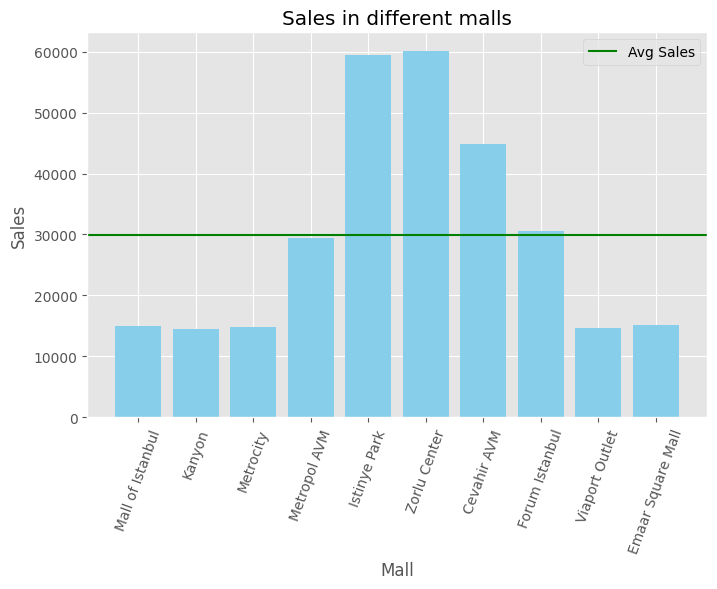

In [19]:
mall = ["Mall of Istanbul",'Kanyon','Metrocity','Metropol AVM','Istinye Park','Zorlu Center','Cevahir AVM','Forum Istanbul','Viaport Outlet','Emaar Square Mall']
fig, ax = plt.subplots(1,1,figsize=(8,5))
avg_sales_mall = sales_mall['quantity'].mean()
ax.bar(sales_mall['shopping_mall'], sales_mall['quantity'], color='skyblue')
ax.set_xticks(range(len(mall)))
# ax.set_xticks(rotation=45)
ax.set_xticklabels(mall,rotation=70)
ax.axhline(y=avg_sales_mall.mean(),color='green',label='Avg Sales')

ax.set_ylabel('Sales')
ax.set_xlabel("Mall")
ax.set_title('Sales in different malls')
plt.legend()
plt.show()

In [20]:
age_grp = df.groupby(['age'])
age_avg_sales = age_grp['quantity'].mean().sort_values(ascending=False)
age_avg_sales = age_avg_sales.to_frame()
conditions = [
    (age_avg_sales <=26),
    (age_avg_sales >26) & (age_avg_sales <40),
    (age_avg_sales >40),
]
values = ['Below_26','Between_27_to_40','Above_40']

age_avg_sales['quantity'] = np.select(conditions,values)
df['age_category'] = df['age'].apply(lambda x: 'Below_26' if x <= 26 else 'Between_27_to_40' if x <= 40 else 'Above_40')

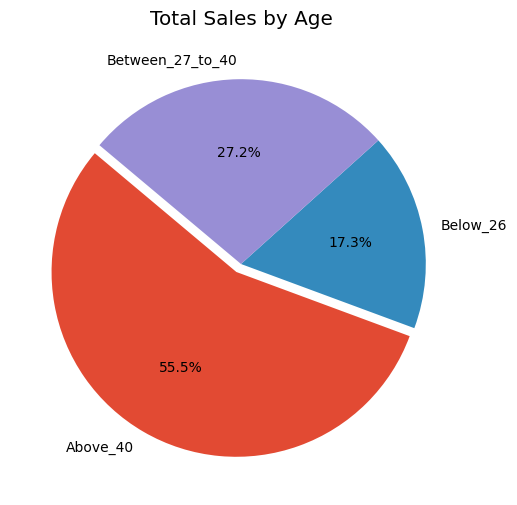

In [21]:
total_sales_by_age_category = df.groupby('age_category')['quantity'].sum().reset_index()

# Plot the pie chart
slices = total_sales_by_age_category['quantity']
labels = total_sales_by_age_category['age_category']
explode = [0.05, 0, 0]

plt.figure(figsize=(6, 6))
plt.pie(slices, labels=labels, explode=explode, autopct='%1.1f%%', startangle=140)
plt.title('Total Sales by Age')
plt.show()

In [22]:
sales_gender_category = df.groupby(['category', 'gender'])['quantity'].sum().unstack()

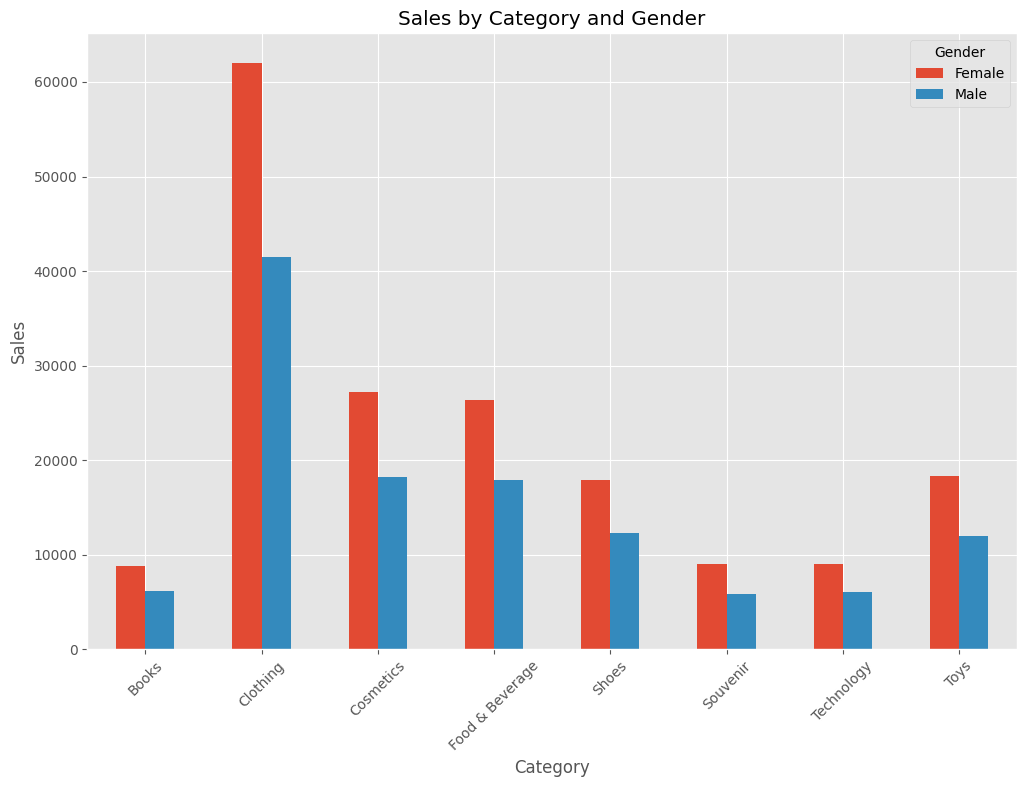

In [23]:
sales_gender_category.plot(kind='bar', figsize=(12, 8))

# Customize the plot
plt.title('Sales by Category and Gender')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

# Recommendations
1. Malls such as Istinye Park, Zorlu Center, Cevahir AVM, and Forum Istanbul have sales above the average sales across all malls.

2. The majority of customers (55.5%) belong to the age group above 40, suggesting that products can be targeted towards this age demographic.

3. Clothing, cosmetics, food & beverages, shoes, and toys were the highest-selling product categories, with females making more purchases than males in these categories.
